In [1]:
from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk

/home/nray/anaconda3/envs/jakaria_tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return image_array, origin, spacing

In [6]:
luna_subset_path = 'subset0/'
file_list=glob(luna_subset_path+"*.mhd")

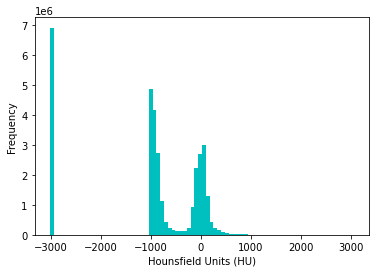

In [7]:
from matplotlib import pyplot as plt

img, origin, spacing = load_itk(file_list[0])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [8]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [9]:
img2, spacing2 = resample(img, spacing)

In [10]:
print(img.shape, spacing)
print(img2.shape, spacing2)

(124, 512, 512) [2.5        0.61523402 0.61523402]
(310, 315, 315) [1.         0.99999942 0.99999942]


In [11]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im

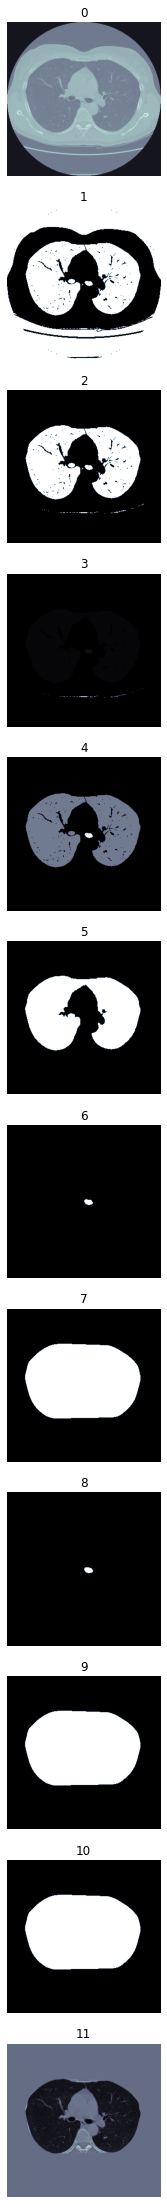

In [12]:
from matplotlib import pyplot as plt
tmp_2d_img = get_segmented_lungs(img2[200,:,:], True)

In [13]:
img3 = np.asarray([get_segmented_lungs(im) for im in img2])

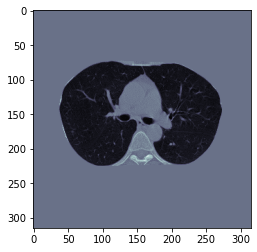

In [14]:
from matplotlib import pyplot as plt
plt.imshow(img3[201,:,:], cmap=plt.cm.bone)
plt.show()

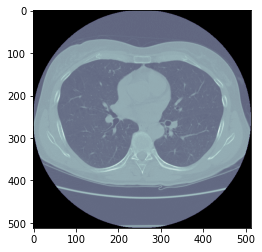

In [26]:

from matplotlib import pyplot as plt
plt.imshow(first_patient_pixels[int(201*124/366),:,:], cmap=plt.cm.bone)
plt.show()

In [19]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [20]:
img4 = normalize(img3)

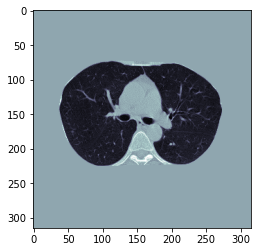

In [21]:
plt.imshow(img4[201,:,:], cmap=plt.cm.bone)
plt.show()

In [23]:
def zero_center(image):
    PIXEL_MEAN = 0.25 * 256
    image2 = image - PIXEL_MEAN
    return image2

In [24]:
img5 = zero_center(img4)

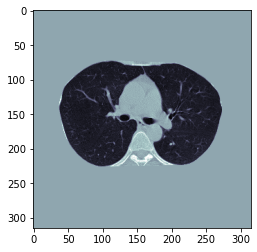

In [25]:
plt.imshow(img5[200,:,:], cmap=plt.cm.bone)
plt.show()

In [2]:
import numpy as np

img_array = np.load('/DATA/jakaria_data/dataset/volumes_modified/s_0001_0363.npy')

In [4]:
img_array.shape

(3, 512, 512)

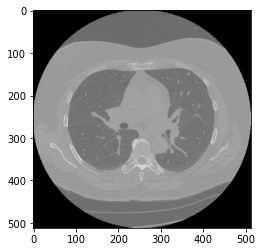

In [5]:
plt.imshow(img_array[0], cmap='gray')
plt.show()